# Import

In [2]:
## General 
import gzip
import pandas as pd
import numpy as np
import requests
import random
import os
import networkx as nx
import pickle
from itertools import accumulate
import regex as re
from os.path import isfile, isdir, join

#sklearn Encode
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
# NLP library
import spacy

# Visulize
import matplotlib.pyplot as plt

# Evaluation
from sklearn import metrics
from sklearn.model_selection import cross_val_score
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

%matplotlib inline

In [5]:
#!/usr/bin/env python3

import keras

from utils import get_auth_number, init_auth_names, data_to_JSON, hot_to_string, get_sample_context

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Layer
from keras.layers.normalization import BatchNormalization
from keras.datasets import imdb
from keras.utils.np_utils import to_categorical
from keras.models import load_model
from keras.optimizers import SGD, Adadelta
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, LearningRateScheduler, Callback
from keras.utils import plot_model, np_utils
from keras.initializers import RandomUniform, RandomNormal

from sklearn.metrics import classification_report, confusion_matrix, roc_curve

from random import shuffle
from shutil import copy as copy_file
from copy import copy, deepcopy
from os import listdir
from os.path import isfile, join
from collections import Counter
from flask import Flask, render_template, request
from multiprocessing import Process

import keras.backend as K
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import unicodedata
import itertools
import gzip
import pickle
import time
import argparse
import signal, psutil
import os
import io
import string
import sys
import numpy
import h5py
import unicodedata
import json
import logging

/home/chesterhsieh/anaconda3/envs/deep-learning/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/chesterhsieh/anaconda3/envs/deep-learning/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [25]:
TXT_PATH = "./txt"

# Download file

## Corups Source
https://web.eecs.umich.edu/~lahiri/gutenberg_dataset.html

In [26]:
ls_corpus = []
for (dirpath, dirnames, filenames) in os.walk(TXT_PATH):
    ls_corpus.extend(filenames)
print("Total Corpus for on Database: {0}".format(len(ls_corpus)))

Total Corpus for on Database: 3037


## Author list

In [27]:
re = requests.get('https://web.eecs.umich.edu/~lahiri/gutenberg_author_list')
ls_author = re.text.splitlines()

## Import file Name

In [28]:
def autohr_identify(ls_author,data_path = TXT_PATH):
    ls_corpus = []
    for (dirpath, dirnames, filenames) in os.walk(data_path):
        ls_corpus.extend(filenames)
        
    ls_Total_corpus = []
    ls_selected_corpus = {}
    for author in ls_author:
        ls_temp = []
        for corpus in ls_corpus:
            if author in corpus:
                ls_temp.append(corpus)
                ls_Total_corpus.append(corpus)
        ls_selected_corpus[author] = ls_temp
    return ls_selected_corpus,ls_Total_corpus

In [29]:
ls_selected_corpus,Total_corpus_count = autohr_identify(ls_author)

In [30]:
ls_selected_author = {}
for author in ls_selected_corpus.keys():
    ls_selected_author[author] = len(ls_selected_corpus[author])

## Writing Number Distribution

    X axis represent # of publication
    Y axis -> # of authors

(array([61., 30., 10., 12., 12.,  6.,  3.,  2.,  3.,  3.]),
 array([ 1. , 10.6, 20.2, 29.8, 39.4, 49. , 58.6, 68.2, 77.8, 87.4, 97. ]),
 <a list of 10 Patch objects>)

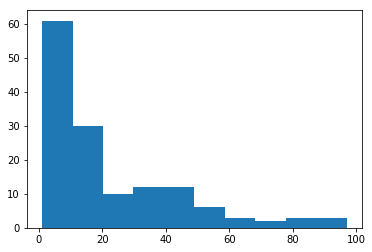

In [31]:
plt.hist(list(ls_selected_author.values()))

## Select 10 author for analysis

### Top 10 writhter

In [32]:
def top_k_public(k = 10):
    ls_author = []
    temp = np.array(list(ls_selected_author.values()))
    for i in np.argpartition(temp, -k)[-k:]:
        ls_author.append(list(ls_selected_author.keys())[i])
    return ls_author

In [33]:
ls_author = top_k_public()
ls_selected_corpus,Total_corpus_count = autohr_identify(ls_author)

In [34]:
print("Total Corpus for selected authors: {0}".format(len(Total_corpus_count)))

Total Corpus for selected authors: 789


### Random 10

In [35]:
# ls_author = re.text.splitlines()
# ls_author = random.sample(ls_author,10)
ls_author = ['Michael Faraday', 'Emily Bronte', 'Charles Darwin', 'Benjamin Franklin', 'John Locke', 'William Dean Howells', 'Walter de la Mare', 'James Russell Lowell', 'Edgar Allan Poe', 'Sir Richard Francis Burton']
ls_selected_corpus,Total_corpus_count = autohr_identify(ls_author)
print('Slected Author List : '+str(ls_author))
print("Total Corpus for selected authors: {0}".format(len(Total_corpus_count)))

Slected Author List : ['Michael Faraday', 'Emily Bronte', 'Charles Darwin', 'Benjamin Franklin', 'John Locke', 'William Dean Howells', 'Walter de la Mare', 'James Russell Lowell', 'Edgar Allan Poe', 'Sir Richard Francis Burton']
Total Corpus for selected authors: 158


In [ ]:
pickle.dump(ls_selected_corpus,open('./embeded_data/'+'ls_selected_corpus.pkl','wb'))

## Clean Corpus 
To prevent cheating. I want to remove header from coupus

# Analysis baseline
    Roughly Idea is apply spacy(pre-trained model) To see the distance bewteen each user,
- Encode the author and corpus
- Using Spacy to encode "corpus"
- Using KNN for analysis
- Leave One Out (LOO) Cross Validation http://scikit-learn.org/stable/modules/cross_validation.html#leave-one-out-loo
- Networkx show distance result

## Preprocessing

In [23]:
nlp = spacy.load('en_core_web_lg')
nlp.max_length = 30000

### Author & Corpusencode

    Using encode label will help later analysis with numpy.

In [22]:
le_author = preprocessing.LabelEncoder()
le_corpus = preprocessing.LabelEncoder()
le_author.fit(ls_author)
le_corpus.fit(Total_corpus_count)

LabelEncoder()

Two reason for slice the corpus:
- To prevent memory shortage issue: Roughly 100,000 charactor need 1 GB ram. Longest corpus takes around 28 GB
- Design model for identify from partial corpus

Nested List:
[Author][Corpus][Section]

In [15]:
def partition(lst, n):
    q, r = divmod(len(lst), n)
    indices = [q*i + min(i, r) for i in range(n+1)]
    return [lst[indices[i]:indices[i+1]] for i in range(n)]

def spacy_encode(ls_selected_corpus,num_partition = 10,path = './embeded_data/'):
    for author in ls_selected_corpus.keys():
#         ls_nested_diminsion = np.zeros((len(ls_selected_corpus[author]),10),dtype=object)
        ls_nested_diminsion = []
        for corpus in ls_selected_corpus[author]:
            ls_temp_corp = []
            f = open(TXT_PATH+'/'+corpus, 'r')
            ls_partition = partition(f.read().splitlines(),num_partition)
            f.close()
            for part in range(num_partition):
                i = le_author.transform([author])[0]
                j = le_corpus.transform([corpus])[0]
                try:
                    ls_temp_corp.append(nlp(str(ls_partition[part])))
                except:
                    print(i,j,part)
                    continue
            ls_nested_diminsion.append(ls_temp_corp)
        pickle.dump(ls_nested_diminsion,open(path+'ls_nested_diminsion_{0}.pkl'.format(author),'wb'))

In [41]:
def spacy_encode(ls_selected_corpus,num_partition = 10,path = './embeded_data/'):
    ls_nested_diminsion = []
    for author in ls_selected_corpus.keys():
        ls_author_temp = []
        for corpus in ls_selected_corpus[author]:
            ls_temp_corp = []
            f = open(TXT_PATH+'/'+corpus, 'r')
            ls_partition = partition(f.read().splitlines(),num_partition)
            f.close()
            for part in range(num_partition):
                i = le_author.transform([author])[0]
                j = le_corpus.transform([corpus])[0]
                ls_temp_corp.append(nlp(str(ls_partition[part])).vector)
            ls_author_temp.append(ls_temp_corp)
        ls_nested_diminsion.append(ls_author_temp)
    return ls_nested_diminsion
#         pickle.dump(ls_nested_diminsion,open(path+'ls_nested_diminsion_{0}.pkl'.format(author),'wb'))

In [42]:
ls_nested_diminsion = spacy_encode(ls_selected_corpus)

In [43]:
pickle.dump(ls_nested_diminsion,open('./embeded_data/'+'ls_nested_diminsion_vector.pkl','wb'))

### Read back from disk

In [67]:
def read_back_from_disk(ls_selected_corpus,path = './embeded_data/'):
    ls_nested_diminsion = []
    ls_pkl_names = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        ls_pkl_names.extend(filenames)
    ls_author = le_author.inverse_transform(range(10))
    for author in ls_author:
        for filename in ls_pkl_names:
            if author in filename:
                ls_nested_diminsion.append(pickle.load(open(path+filename,'rb')))
    return ls_nested_diminsion

In [68]:
ls_nested_diminsion = read_back_from_disk(ls_selected_corpus)

/home/chesterhsieh/anaconda3/envs/deep-learning/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Corpus Length distribution

(array([25., 22., 19., 26., 27.,  6.,  1.,  2.,  1.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  23539. ,  156758.3,  289977.6,  423196.9,  556416.2,  689635.5,
         822854.8,  956074.1, 1089293.4, 1222512.7, 1355732. , 1488951.3,
        1622170.6, 1755389.9, 1888609.2, 2021828.5, 2155047.8, 2288267.1,
        2421486.4, 2554705.7, 2687925. ]),
 <a list of 20 Patch objects>)

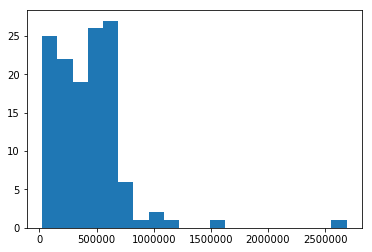

In [36]:
plt.hist(ls_count,bins=20)

## Clean Raw text Pipeline

In [13]:
with open(TXT_PATH+'/'+ls_selected_corpus[0], 'r') as f:
    temp_str = f.read()
    a = nlp(temp_str)
with open(TXT_PATH+'/'+ls_selected_corpus[1], 'r') as f:
    temp_str = f.read()
    b = nlp(temp_str)

In [29]:
a.similarity(b)

0.9432276950298315

In [15]:
a.similarity(b)

0.9432276950298315

## Similarity Matrix
- Flatten Matrx
- Do pairwise distance

In [25]:
ls_nested_diminsion = pickle.load(open('./embeded_data/'+'ls_nested_diminsion.pkl','rb'))

In [26]:
ls_flat_diminsion = [item for sublist in ls_nested_diminsion for item in sublist]
ls_flat_diminsion = [item for sublist in ls_flat_diminsion for item in sublist]

In [27]:
mat_similarity = cosine_similarity(ls_flat_diminsion)

In [53]:
ls_corpus_ind = [len(author) for author in ls_nested_diminsion]# #of corpus belong each author

## Similairty Plot

In [37]:
scaler = MinMaxScaler()
mat_similarity = scaler.fit_transform(mat_similarity)

In [55]:
print('Author & Corpus Index Range:')
ls_corpus_ind = np.array(ls_corpus_ind)*10
print(list(accumulate(ls_corpus_ind)))

Author & Corpus Index Range:
[30, 130, 340, 450, 470, 480, 1320, 1430, 1540, 1580]


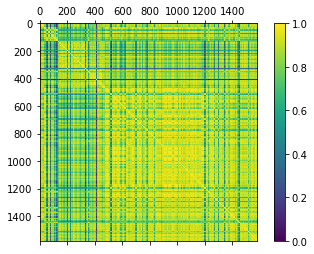

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(mat_similarity, vmin=0, vmax=1)
fig.colorbar(cax)
ticks = numpy.arange(0,9,1)
plt.show()

## KNN

In [60]:
def y_label_generate(ls_corpus_ind):
    Y = []
    num_author = len(ls_corpus_ind)
    for i in range(num_author):
        Y.extend([i]*(ls_corpus_ind[i]))
    return Y

In [61]:
Y = y_label_generate(ls_corpus_ind)

In [74]:
neigh = KNeighborsClassifier(n_neighbors=3)
# neigh.fit(ls_flat_diminsion, Y) 

In [75]:
scores = cross_val_score(neigh, ls_flat_diminsion, Y, cv=5, scoring='f1_macro')

In [77]:
print("Five different Cross-Validation Result:",scores)

Five different Cross-Validation Result: [0.87171959 0.87967261 0.87896195 0.89549315 0.85135439]


### Evaluation- Same Partition

### Ramdom pick Paragrah

# CNN
    Using Keras build CNN network for traing

## Init

In [3]:
ls_author = ['Michael Faraday', 'Emily Bronte', 'Charles Darwin', 'Benjamin Franklin', 'John Locke', 'William Dean Howells', 'Walter de la Mare', 'James Russell Lowell', 'Edgar Allan Poe', 'Sir Richard Francis Burton']


In [4]:
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

vect_size = len(alphabet)
batch_size = 128
filters = 256
kernel_size = [3, 2]
hidden_dims = 2048
epochs = 300
pool_size = 2
epoch_decay = 60
initial_lr = 0.001
decay_rate = 0.5
max_features = 376

target_names = ls_author

# hyperparameters = {'alphabet':alphabet, 'vect_size':vect_size, 'batch_size':batch_size, 'filters':filters, 'kernel_size':kernel_size, 
# 'hidden_dims':hidden_dims, 'epochs':epochs, 'pool_size':pool_size, 'epoch_decay':eapoch_decay, 'initial_lr':initial_lr,
# 'decay_rate':decay_rate, 'max_features':max_features, 'target_names':target_names}
hyperparameters = {'alphabet':alphabet, 'vect_size':vect_size, 'batch_size':batch_size, 'filters':filters, 'kernel_size':kernel_size, 
'hidden_dims':hidden_dims, 'epochs':epochs, 'pool_size':pool_size,  'initial_lr':initial_lr,
'decay_rate':decay_rate, 'max_features':max_features, 'target_names':target_names}

## Preprocess corpus

In [6]:
def clean_text(inputFile, outputFile):

    last_char = ''

    opening_header = [u'Project Gutenberg', u'Project gutenberg', u'project gutenberg']
    opening_footer = [u'END OF', u'End of']

    closure_header = [u'START OF', u'Start of']
    closure_footer = [u'subscribe']

    useless_chars = [u'_']

    useless_pattern = [re.compile("<.+>"), re.compile("</.+>")]

    skip_patterns = [u'=>', u'<=', u'       ']

    opening_chars = [u'(', u'[', u'{']
    closure_chars = [u')', u']', u'}']
    flags_chars = [0, 0, 0]
    dont_write_char = 0
    dont_write_line = 0
    skip_line = 1


    with io.open(inputFile, 'r', encoding='utf-8-sig', errors='ignore') as input_file, io.open(outputFile, 'w', encoding='utf-8-sig') as output_file:
        for line in input_file:

            if any(op_h in line for op_h in opening_header) or any(op_f in line for op_f in opening_footer):
                dont_write_line = 1

            elif re.compile("Produced").match(line):
                skip_line += 5

            elif line.isupper() and not (any(op_c in line for op_c in opening_chars) or any(cl_c in line for cl_c in closure_chars)):
                skip_line += 1

            elif not line.strip():
                skip_line += 1

            else:
                for pattern in skip_patterns:
                    if pattern in line and not any(op_c in line for op_c in opening_chars) and not any(cl_c in line for cl_c in closure_chars):
                        skip_line += 1
                        break

                for pattern in useless_pattern:
                    if pattern.search(line):
                        line = re.sub(pattern, "", line)


            if dont_write_line == 0 and skip_line == 0:
                for char in line:
                    if not char in useless_chars:

                        if char in opening_chars:
                            flags_chars[opening_chars.index(char)] += 1

                        if last_char == u'>':
                            if char == u'>':
                                char = u' »'
                            elif not any(flag > 0 for flag in flags_chars):
                                output_file.write(u">")

                        elif char == u'>':
                            dont_write_char = 1

                        if last_char == u'<':
                            if char == u'<':
                                char = u'« '
                            elif not any(flag > 0 for flag in flags_chars):
                                output_file.write(u"<")

                        elif char == u'<':
                            dont_write_char = 1

                        if last_char == u'-':
                            if char == u'-':
                                char = u'— '
                            elif not any(flag > 0 for flag in flags_chars):
                                output_file.write(u"-")

                        elif char == u'-':
                            dont_write_char = 1

                        if all(flag == 0 for flag in flags_chars) and dont_write_char == 0:
                            output_file.write(char)

                        elif char in closure_chars:
                            flags_chars[closure_chars.index(char)] -= 1

                        dont_write_char = 0
                        last_char = char

            elif any(cl_h in line for cl_h in closure_header) or any(cl_f in line for cl_f in closure_footer):
                dont_write_line = 0

            if skip_line > 0:
                skip_line -= 1


In [ ]:
# for file in ls_corpus:
#     clean_text('./txt/{0}'.format(file),'./clean_txt/{0}'.format(file))

## Create Train & Test Set

In [15]:
def load_data_text(hyperparameters):
    # The following loads and format the data stored in the folder named "Text"
    # The architecture must be the following:
    # Text --| Author1 --| Result --| input_*.txt
    #		| Author2 --| Result --| input_*.txt
    #		| Author3 --| Result --| input_*.txt

    print('\n[*] Loading data')

    directory = "train"

    data_vector = []
    train_set_x = []
    train_set_y = []
    test_set_x = []
    test_set_y = []

    count_author = -1
    letter_vector = [0] * len(hyperparameters['alphabet'])
    example_vector = []

#     for subdir in next(os.walk(directory))[1]:
#         if listdir(join(directory, subdir)):
#             hyperparameters['target_names'].append(subdir)

    hyperparameters['target_names'].sort()
    
    for author in hyperparameters['target_names']:
        count_author += 1
        for file in ls_selected_corpus[author]:
            i = 1
            with open('./clean_txt/{0}'.format(file), "r") as text:
                target = le_author.transform([author])[0]
                example_vector = []
                for line in text:
                    line = ''.join((c for c in unicodedata.normalize('NFD', line) if unicodedata.category(c) != 'Mn'))
                    for character in line.lower():
                        if character in hyperparameters['alphabet']:
                            letter_vector = [0] * len(hyperparameters['alphabet'])
                            letter_vector[hyperparameters['alphabet'].index(character)] = 1
                            example_vector.append(letter_vector)
                            if (i%hyperparameters['max_features']) == 0:
                                data_vector.append((numpy.array(example_vector), target))
                                example_vector = []
                            i+=1
        print("Finish author{0}".format(author))

#     assert hyperparameters['target_names'] == init_auth_names([]), '[!] Two set of authors found.'
#     # assert hyperparameters['target_names'] == fixed_author_names, '(!!!) New target names different from fixed_author_names (!!!)'

    random.shuffle(data_vector)

    for element in data_vector:
      train_set_x.append(element[0])
      train_set_y.append(element[1])

    dim = 0.7*len(data_vector)

    test_set_x = train_set_x[int(dim):]
    test_set_y = train_set_y[int(dim):]
    train_set_x = train_set_x[:int(dim)]
    train_set_y = train_set_y[:int(dim)]

    train_set_x = keras.preprocessing.sequence.pad_sequences(train_set_x)
    test_set_x = keras.preprocessing.sequence.pad_sequences(test_set_x)

#     train_set_y = keras.utils.np_utils.to_categorical(train_set_y, get_auth_number())
#     test_set_y = keras.utils.np_utils.to_categorical(test_set_y, get_auth_number())

    train_set_y = keras.utils.np_utils.to_categorical(train_set_y, 10)
    test_set_y = keras.utils.np_utils.to_categorical(test_set_y, 10)
    
    with gzip.GzipFile(join('train', 'formatted_data_train.pkl.gzip'), 'wb') as pkl_file:
      pickle.dump((train_set_x, train_set_y, test_set_x, test_set_y), pkl_file)


    rval = [train_set_x, train_set_y, test_set_x, test_set_y]

    return rval

In [16]:
# hyperparameters['target_names'] = [ls_author[-1]]
# load_data_text(hyperparameters)

## Train Model

In [7]:
import os
import gzip
import pickle
def load_text_from_save():
    ls_zip_files = []
    for (dirpath, dirnames, filenames) in os.walk('./train'):
        ls_zip_files.extend(filenames)
    ls_x_train = []
    ls_y_train = []
    ls_x_test = []
    ls_y_test = []
    for file in ls_zip_files:
        with gzip.GzipFile(os.path.join('train', file), 'rb') as pkl_file:
            x_train, y_train, x_test, y_test = (pickle.load(pkl_file))
        ls_x_train.append(x_train)
        ls_y_train.append(y_train)
        ls_x_test.append(x_test)
        ls_y_test.append(y_test)
    x_train = np.concatenate(ls_x_train,axis = 0)
    y_train = np.concatenate(ls_y_train,axis = 0)
    x_test = np.concatenate(ls_x_test,axis = 0)
    y_test = np.concatenate(ls_y_test,axis = 0)
    return [x_train, y_train, x_test, y_test]

In [8]:
tran_set = load_text_from_save()

In [9]:
pickle.dump(tran_set,open("./train/tran_set.pkl","wb"))

In [13]:
def train_model(x_train, y_train, x_test, y_test, hyperparameters, log_dir):


    # 	def signal_handler(signal, frame):
    # 		model.stop_training = True


    # 	signal.signal(signal.SIGINT, signal_handler)

    print('\n[*] Building Model')
    model = Sequential()

    random_uni = RandomNormal(mean = 0.0, stddev = 0.05, seed = None)

    def custom_sigmoid_activation(x):
        return 1.7159*K.tanh(2/3*x)

    # We initially follow the architecture given here : https://papers.nips.cc/paper/5782-character-level-convolutional-networks-for-text-classification.pdf
    model.add(Conv1D(hyperparameters['filters'],
                     hyperparameters['kernel_size'][0],
                     kernel_initializer=random_uni,
                     input_shape=(hyperparameters['max_features'],hyperparameters['vect_size'])))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling1D(pool_size = 2, strides=None))

    model.add(Conv1D(hyperparameters['filters'],
                     hyperparameters['kernel_size'][1],
                     kernel_initializer=random_uni,
                     strides=1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling1D(pool_size = 2, strides=None))

    model.add(Conv1D(hyperparameters['filters'],
                     hyperparameters['kernel_size'][1],
                     kernel_initializer=random_uni,
                     strides=1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv1D(hyperparameters['filters'],
                     hyperparameters['kernel_size'][1],
                     kernel_initializer=random_uni,
                     strides=1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv1D(hyperparameters['filters'],
                     hyperparameters['kernel_size'][1],
                     kernel_initializer=random_uni,
                     strides=1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling1D(pool_size = 2, strides=None))

    model.add(Flatten())

    model.add(Dense(hyperparameters['hidden_dims'], kernel_initializer=random_uni))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(hyperparameters['hidden_dims'], kernel_initializer=random_uni))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(len(hyperparameters['target_names']), kernel_initializer=random_uni, activation='softmax'))

    sgd = SGD(lr=hyperparameters['initial_lr'], momentum=0.9)

    last_val_loss = float("inf")

    class BoldScheduler(Callback):
        def __init__(self):
            self.last_val_loss = float("inf")

        def on_epoch_end(self, epoch, logs={}):

            curr_val_loss = logs.get('val_loss')
            lr = K.get_value(model.optimizer.lr)

            if(self.last_val_loss > curr_val_loss):
                K.set_value(model.optimizer.lr, lr*1.1)
                print("[*] lr changed from {:.6f} to {:.6f}".format(lr, K.get_value(model.optimizer.lr)))
            elif curr_val_loss - self.last_val_loss > 0.001:
                K.set_value(model.optimizer.lr, lr*0.7)
                print("[*] lr changed from {:.6f} to {:.6f}".format(lr, K.get_value(model.optimizer.lr)))

            self.last_val_loss = curr_val_loss
            return

    def scheduler(epoch):

        if epoch%epoch_decay == 0 and epoch != 0:
            lr = K.get_value(model.optimizer.lr)
            K.set_value(model.optimizer.lr, lr*decay_rate)
            print("[*] lr changed to {}".format(lr*decay_rate)) 
        return K.get_value(model.optimizer.lr)

    checkpointer = ModelCheckpoint(filepath=log_dir + '/model.hdf5', verbose=1, save_best_only=True, monitor='val_categorical_accuracy')
    tensorVizualisation = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    earlyStop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='auto')
    lr_decay = LearningRateScheduler(scheduler)
    bold_decay = BoldScheduler()

    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['categorical_accuracy'])

    plot_model(model, to_file='model.png')

    model.fit(x_train, y_train,
              batch_size=hyperparameters['batch_size'],
              epochs=hyperparameters['epochs'],
              verbose=1,
              validation_data = (x_test, y_test),
              shuffle=True,
              callbacks=[checkpointer, tensorVizualisation])


    copy_file(log_dir + '/model.hdf5', './model' + '/last.hdf5')

    return model

In [10]:
tran_set = pickle.load(open("./train/tran_set.pkl","rb"))

In [ ]:
train_model(tran_set[0], tran_set[1], tran_set[2], tran_set[3], hyperparameters, './log')


[*] Building Model
Train on 62403 samples, validate on 26745 samples
Epoch 1/300
62403/62403 [==============================] - 738s 12ms/step - loss: 1.8374 - categorical_accuracy: 0.4777 - val_loss: 1.4950 - val_categorical_accuracy: 0.5742

In [ ]:
tran_set[1].shape

## Transfer Learning

### Import exitst model
    I use previous train result. Because Computing Power. I only excute 87 epochs

# Multiple Language

## Pre-trained Model

## Transfer Learning

In [19]:
import nltk